In [179]:
# required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import warnings


## Purspoe

Explore the `df_metric_score_metric_target_miss_streak` and `df_metric_score_metric_underperformance_streak`, created in the previous step ("03_data_transformation").


## Data Load

Load the pickle files from '~/data' directory, along with metrics target list.

In [180]:
df_metric_score_metric_target_miss_streak = pd.read_pickle("../data/case_data_target_miss_streak.pkl")
df_metric_score_metric_underperformance_streak = pd.read_pickle("../data/case_data_performance_miss_streak.pkl")

metric_target_definition = {
    "average_responses_agg_month": 4,
    "caseloads_months": 337,
    "chart_review_months": 0.80,
    "documentation_rates_months": 0.90, 
    "mic_utilization_rate_months": 0.80
}

## Metrics Line Graph, specified provider 
Create a line graph for given provider.

In [181]:
def create_line_graph(df, provider_id):

    df_plot = df.query(f"provider_id == {provider_id}")

    sns.set(style="whitegrid")
    g = sns.FacetGrid(df_plot, col="metric_source", col_wrap=2, height=3, aspect=2.5, sharey=False)
    g.map_dataframe(sns.lineplot, x="month_year", y="metric_score_imputed", marker="o")

    # Overlay imputed points with a different color
    for ax, (metric_source, data) in zip(g.axes.flat, df_plot.groupby("metric_source")):
        imputed_data = data[data["is_imputed"]]
        ax.scatter(imputed_data["month_year"], imputed_data["metric_score_imputed"], marker = 'x', color='red', label='Imputed', zorder=5)
        
        # Add horizontal line for target
        target_value = metric_target_definition[metric_source]
        ax.axhline(y=target_value, color='black', linestyle='--', label='Target')
        
        # Add text annotation for the target value
        ax.text(1.01, target_value, f'{target_value}', transform=ax.get_yaxis_transform(), color='black', va='center')

    # Adjust the arrangement of the plots
    g.set_titles("{col_name}")
    g.set_axis_labels("Month/Year", "Metric Score")

    # Rotate x-axis tick names
    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')

    # Add a legend for the imputed points and target line
    handles = [
        plt.Line2D([0], [0], marker='x', color='red', linestyle='None', markersize=8, label='Imputed'),
        plt.Line2D([0], [0], color='black', linestyle='--', label='Target')
    ]
    ax.legend(handles=handles)

    # Add buffer space between the grid
    g.fig.subplots_adjust(hspace=0.1, wspace=0.2)

    g.fig.suptitle(f"Metrics performance over time - Provider #{provider_id}", fontsize=16, y=1.03)

    plt.show()

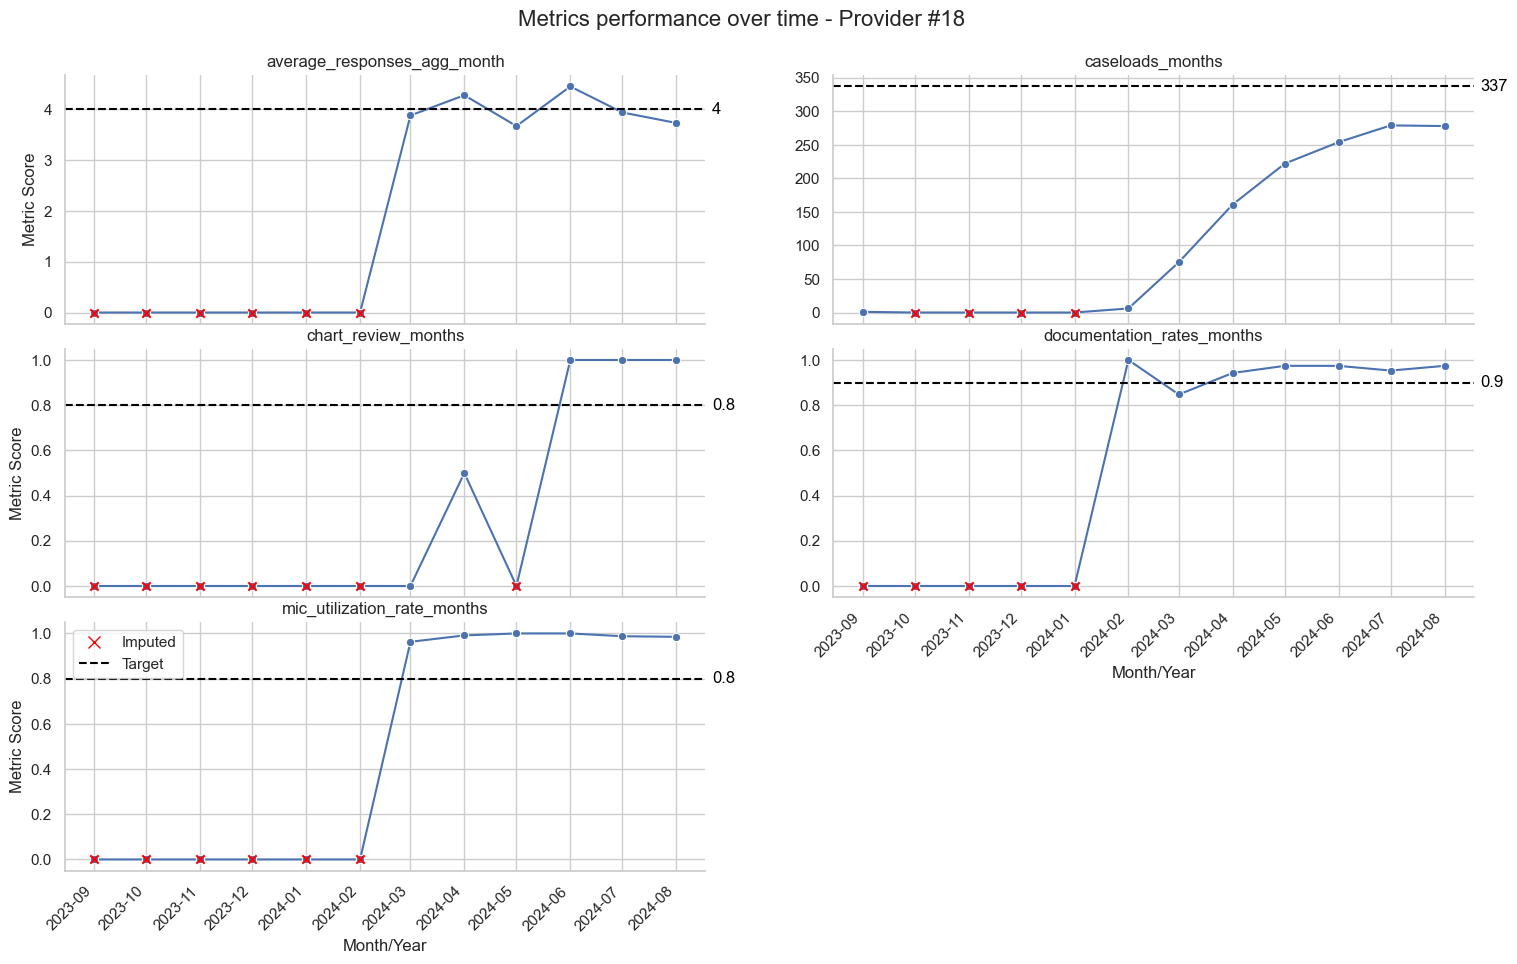

In [205]:
create_line_graph(df_metric_score_metric_target_miss_streak, provider_id = 18)

## Heatmap, all metrics for all provider
Create a heatmap for all provider

In [128]:
def plot_heatmap(df, metric_name, metric_target_definition, provider_filter = [], height = 8):

    query_string = f"metric_source == '{metric_name}'"

    if provider_filter and isinstance(provider_filter, list) and len(provider_filter) > 0:
        query_string += f" & provider_id.isin({provider_filter})"

    df_plot = df.query(query_string)

    metric_target = metric_target_definition[metric_name]
    df_plot['month_year'] = df_plot['month_year'].dt.strftime('%Y-%m')

    df_plot = df_plot\
        .pivot(index="provider_id", columns="month_year", values="metric_score_imputed")

    plt.figure(figsize=(10, height))
    plt.title(f"{metric_name} performance - target: {metric_target}")

    sns.heatmap(
        df_plot,
        annot=True,
        fmt=".1f",
        cmap=["orange",'green'],
        center=metric_target,
        linewidths=0.5,
        annot_kws={"fontsize": 8}
    )

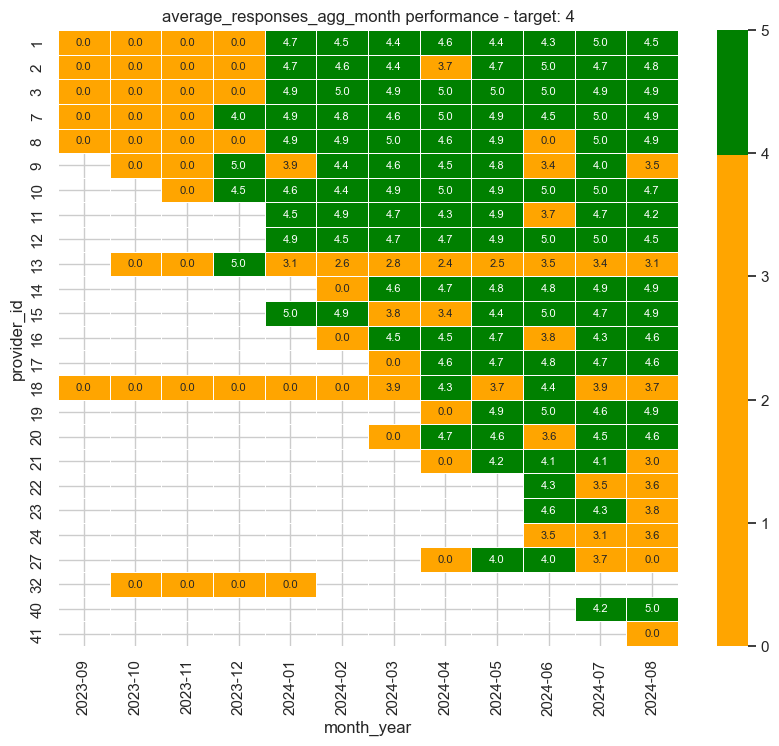

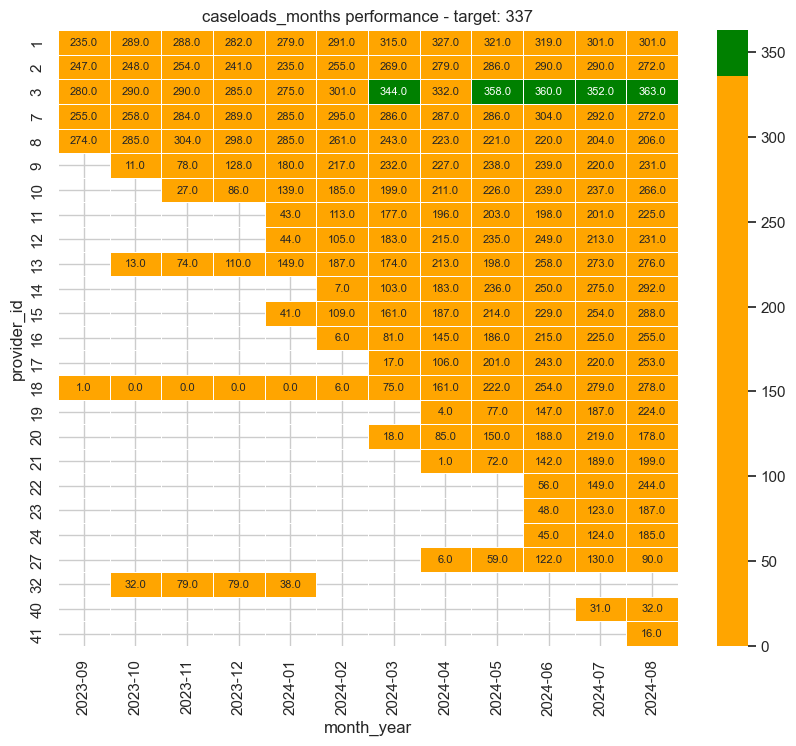

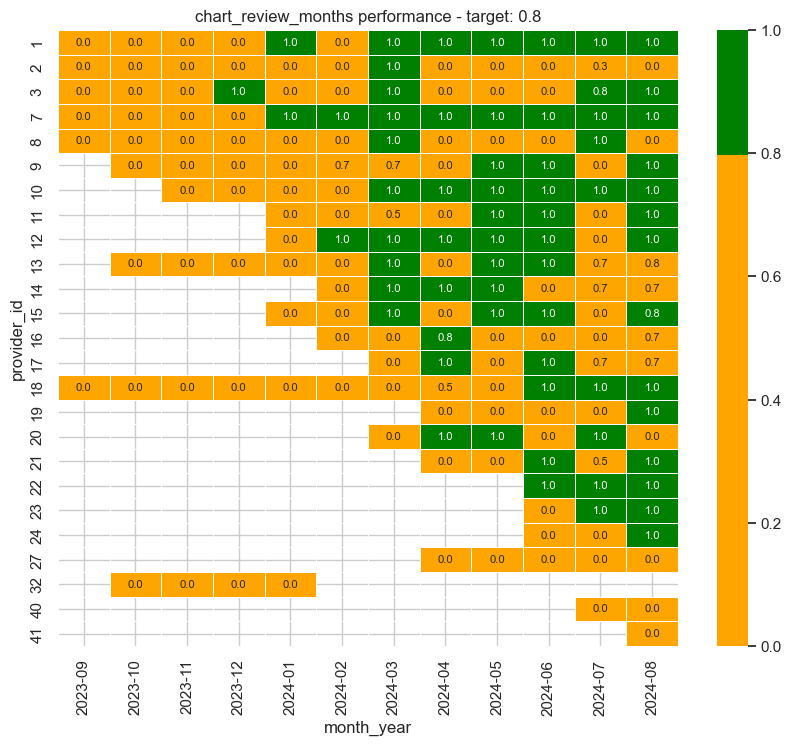

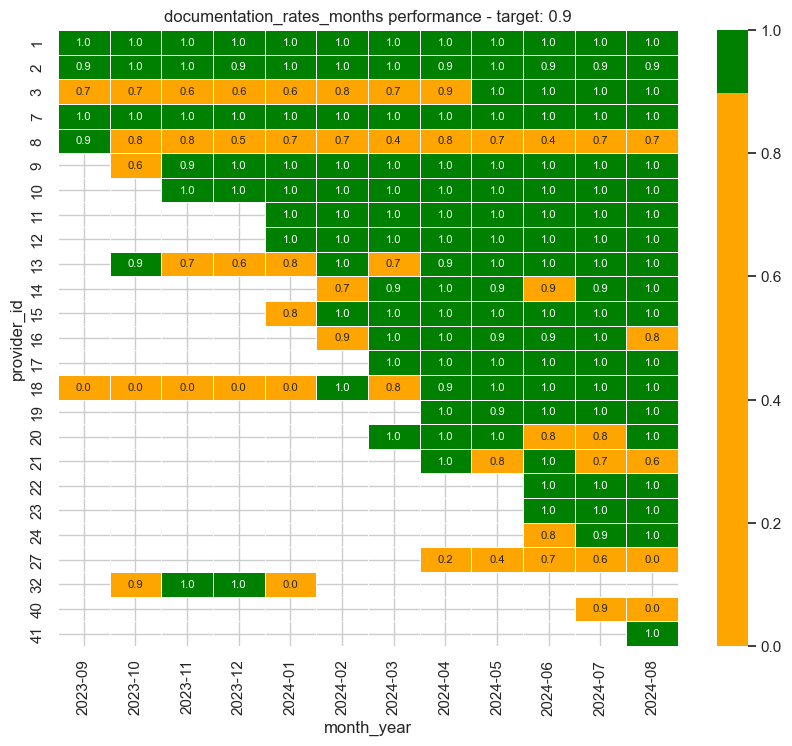

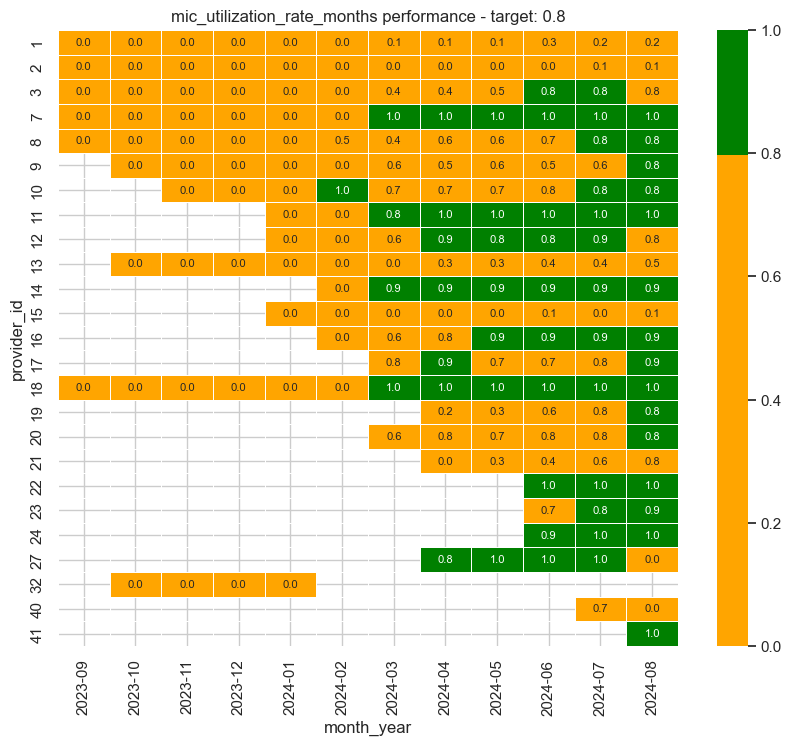

In [141]:
metric_target_definition = {
    "average_responses_agg_month": 4,
    "caseloads_months": 337,
    "chart_review_months": 0.80,
    "documentation_rates_months": 0.90, 
    "mic_utilization_rate_months": 0.80
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore") 

    for metric in df_metric_score_metric_target_miss_streak.metric_source.unique():
        plot_heatmap(df_metric_score_metric_target_miss_streak, metric, metric_target_definition)

## Heatmap, performance target for all providers
Create a line graph for given provider.

In [158]:
def plot_heatmap_performance(df, metric_target, provider_filter = [], height = 8):

    df_plot = df.copy()

    if provider_filter and isinstance(provider_filter, list) and len(provider_filter) > 0:
        df_plot = df_plot.query(f"provider_id.isin({provider_filter})")

    df_plot['month_year'] = df_plot['month_year'].dt.strftime('%Y-%m')

    df_plot = df_plot\
        .pivot(index="provider_id", columns="month_year", values="total_num_metric_target_met")

    plt.figure(figsize=(10, height))
    plt.title(f"Total metric performance - target: {metric_target} out of 5")

    sns.heatmap(
        df_plot,
        annot=True,
        fmt=".1f",
        cmap=["orange",'green'],
        center=metric_target,
        linewidths=0.5,
        annot_kws={"fontsize": 8}
    )

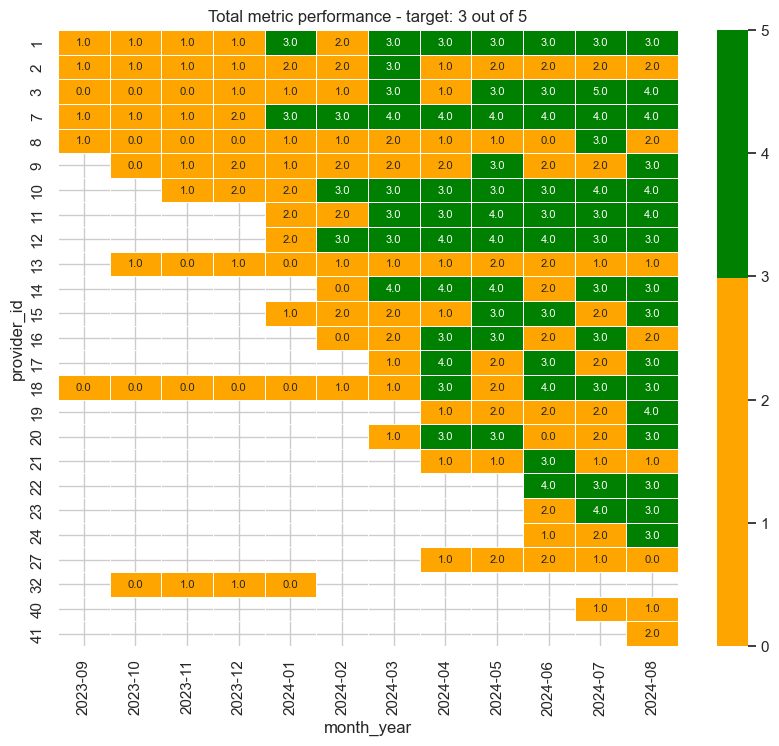

In [159]:
plot_heatmap_performance(df_metric_score_metric_underperformance_streak, 3)

### Closer Look: Providers underperforming

Following providers seems to be missing more than 2 of their target metrics consistently. 
They are provider #2, 8, 9, 13, 19, 21, 17

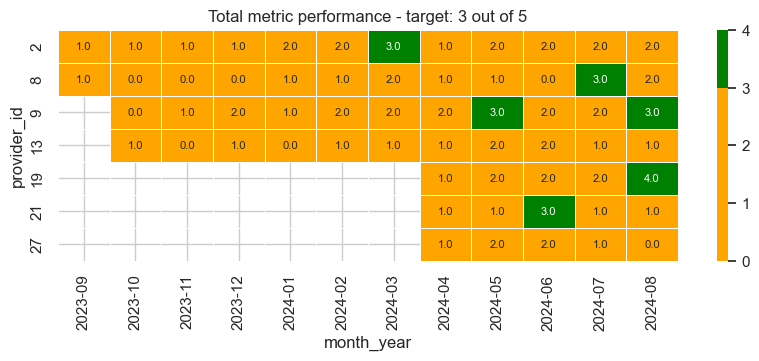

In [176]:
provider_performance_watch_list = [2, 8, 9, 13, 19, 21, 27]
plot_heatmap_performance(df_metric_score_metric_underperformance_streak, 3, provider_performance_watch_list, 3)

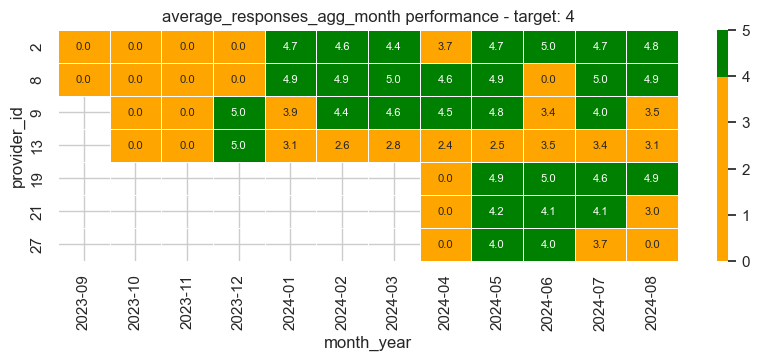

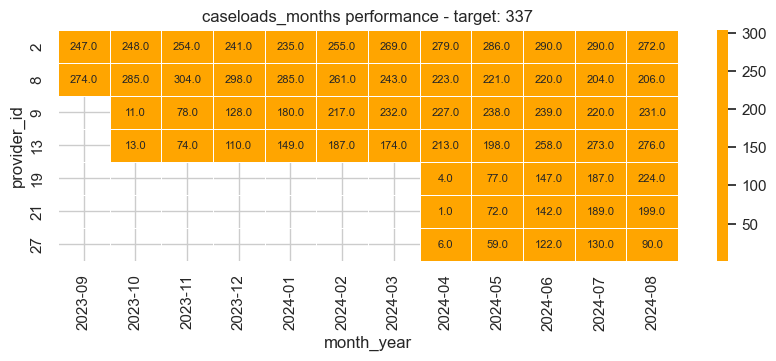

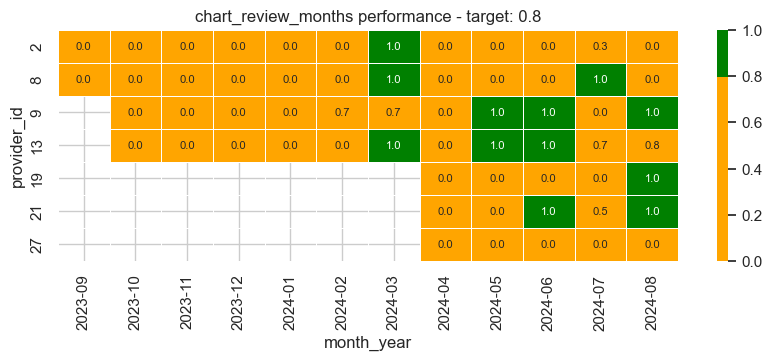

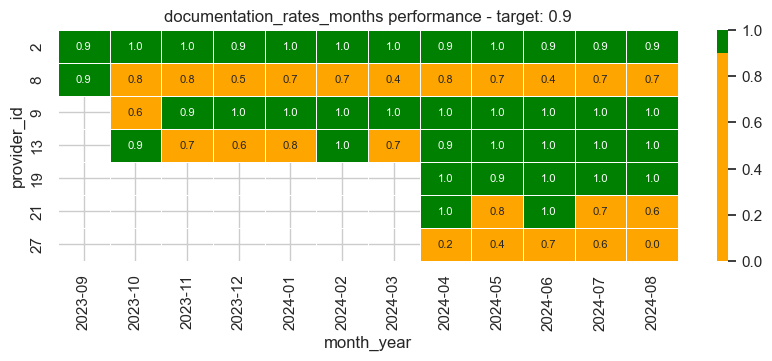

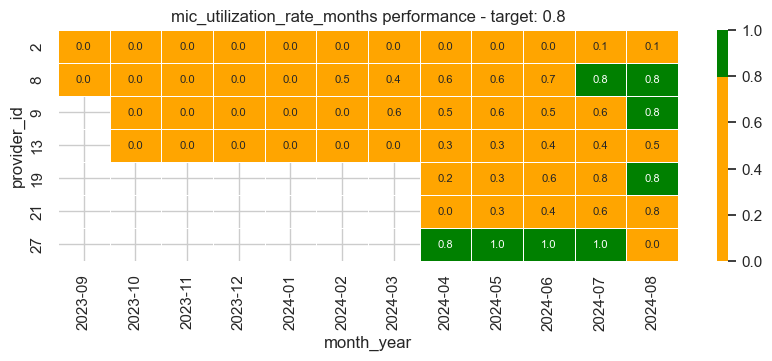

In [177]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 

    for metric in df_metric_score_metric_target_miss_streak.metric_source.unique():
        plot_heatmap(df_metric_score_metric_target_miss_streak, metric, metric_target_definition, provider_performance_watch_list, 3)

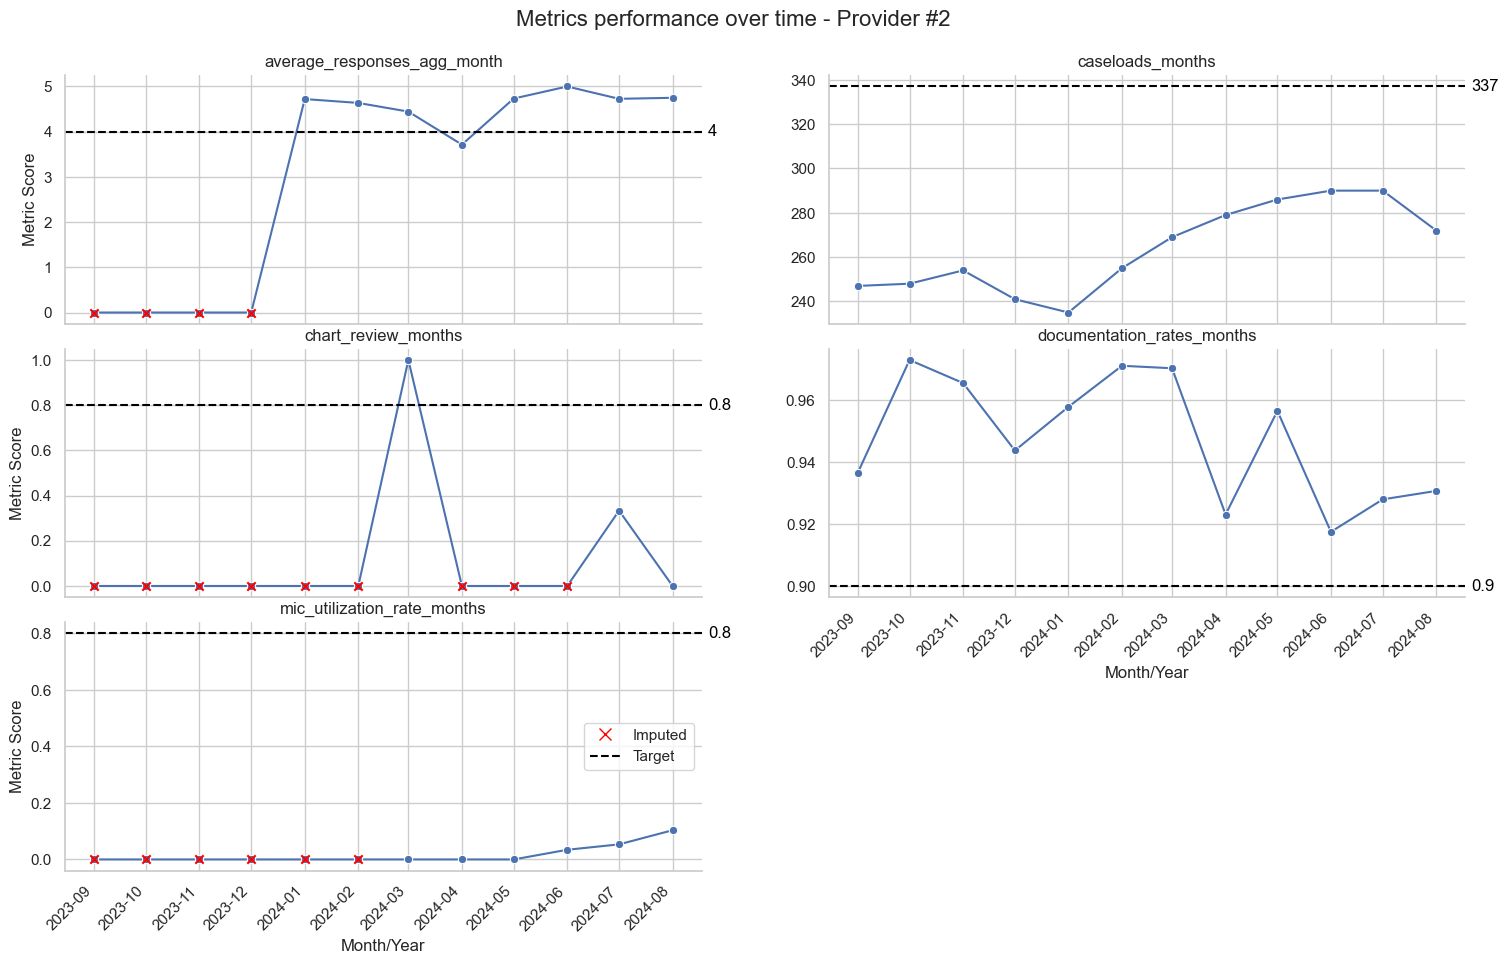

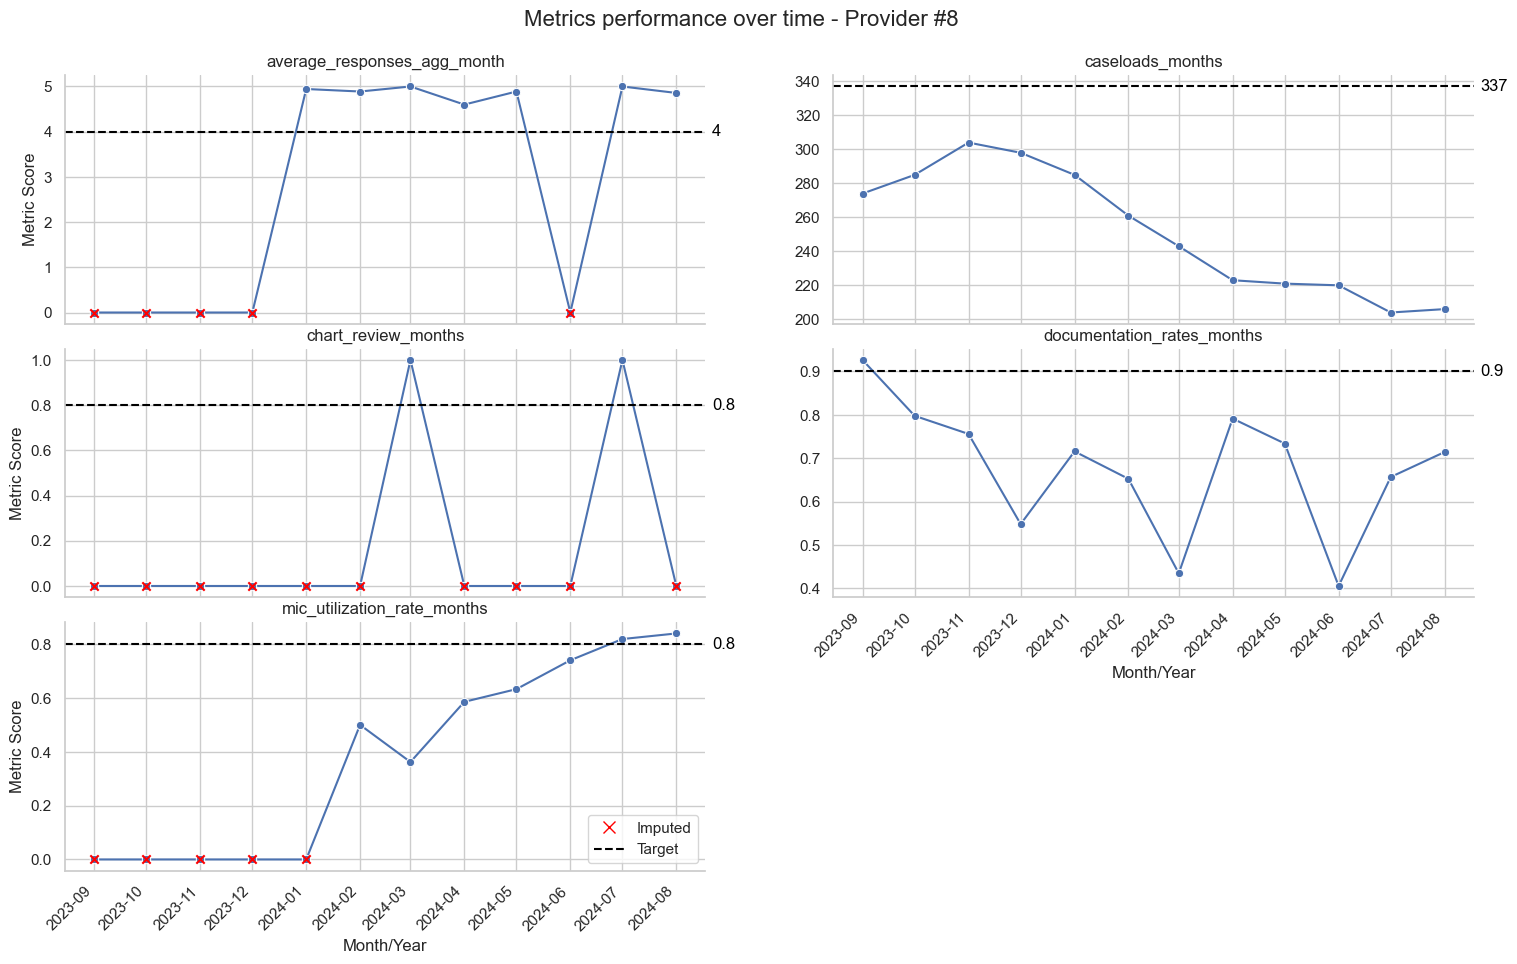

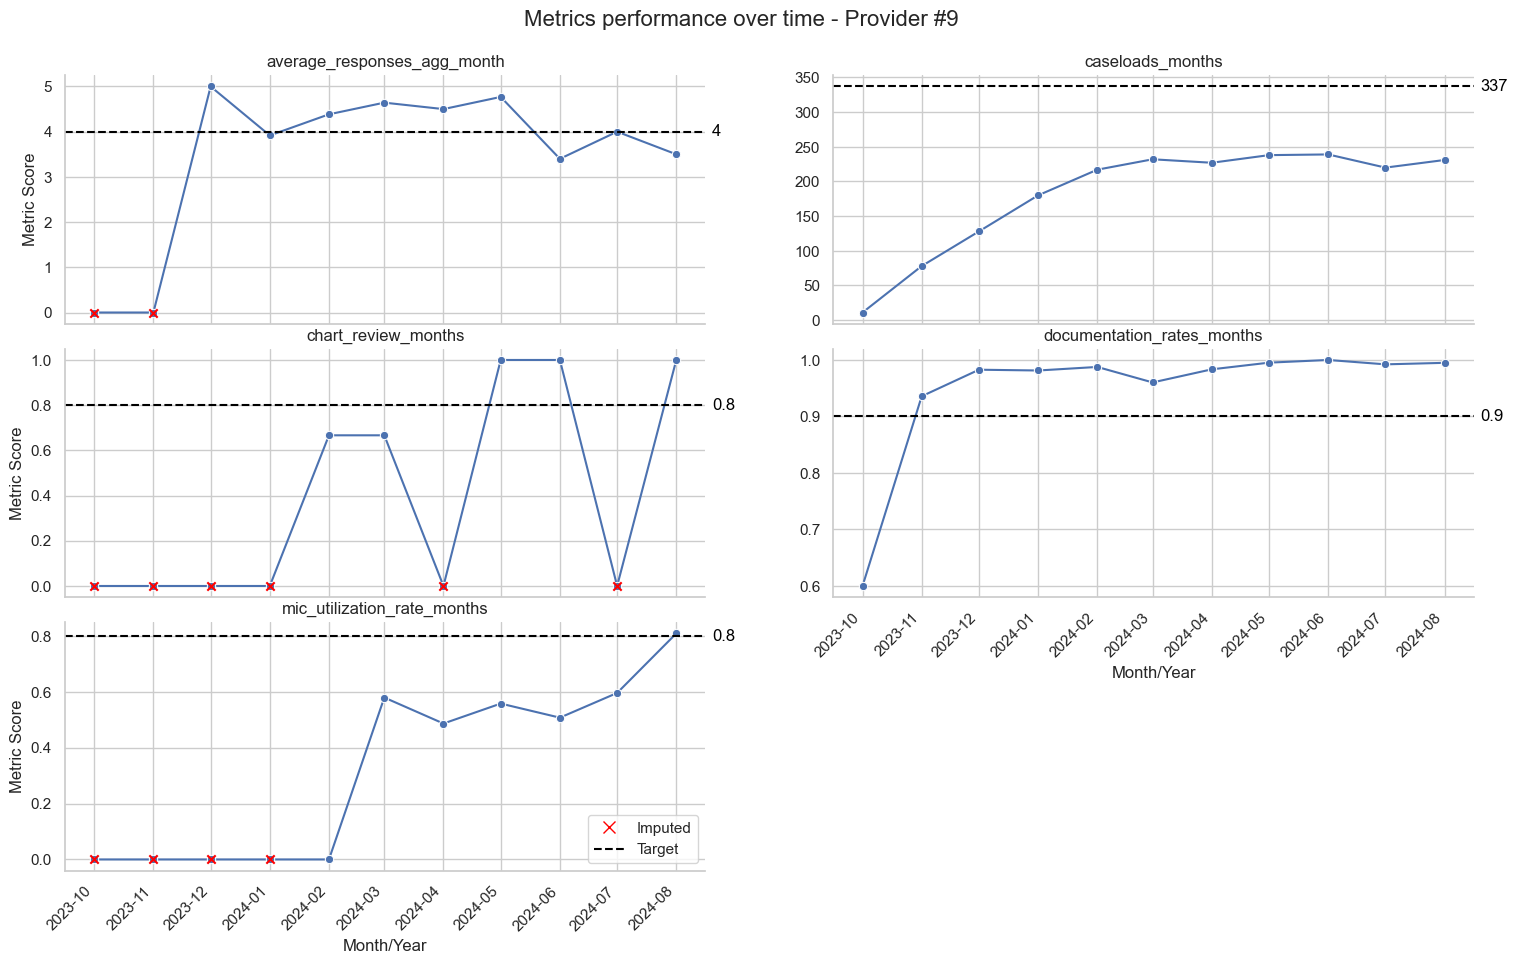

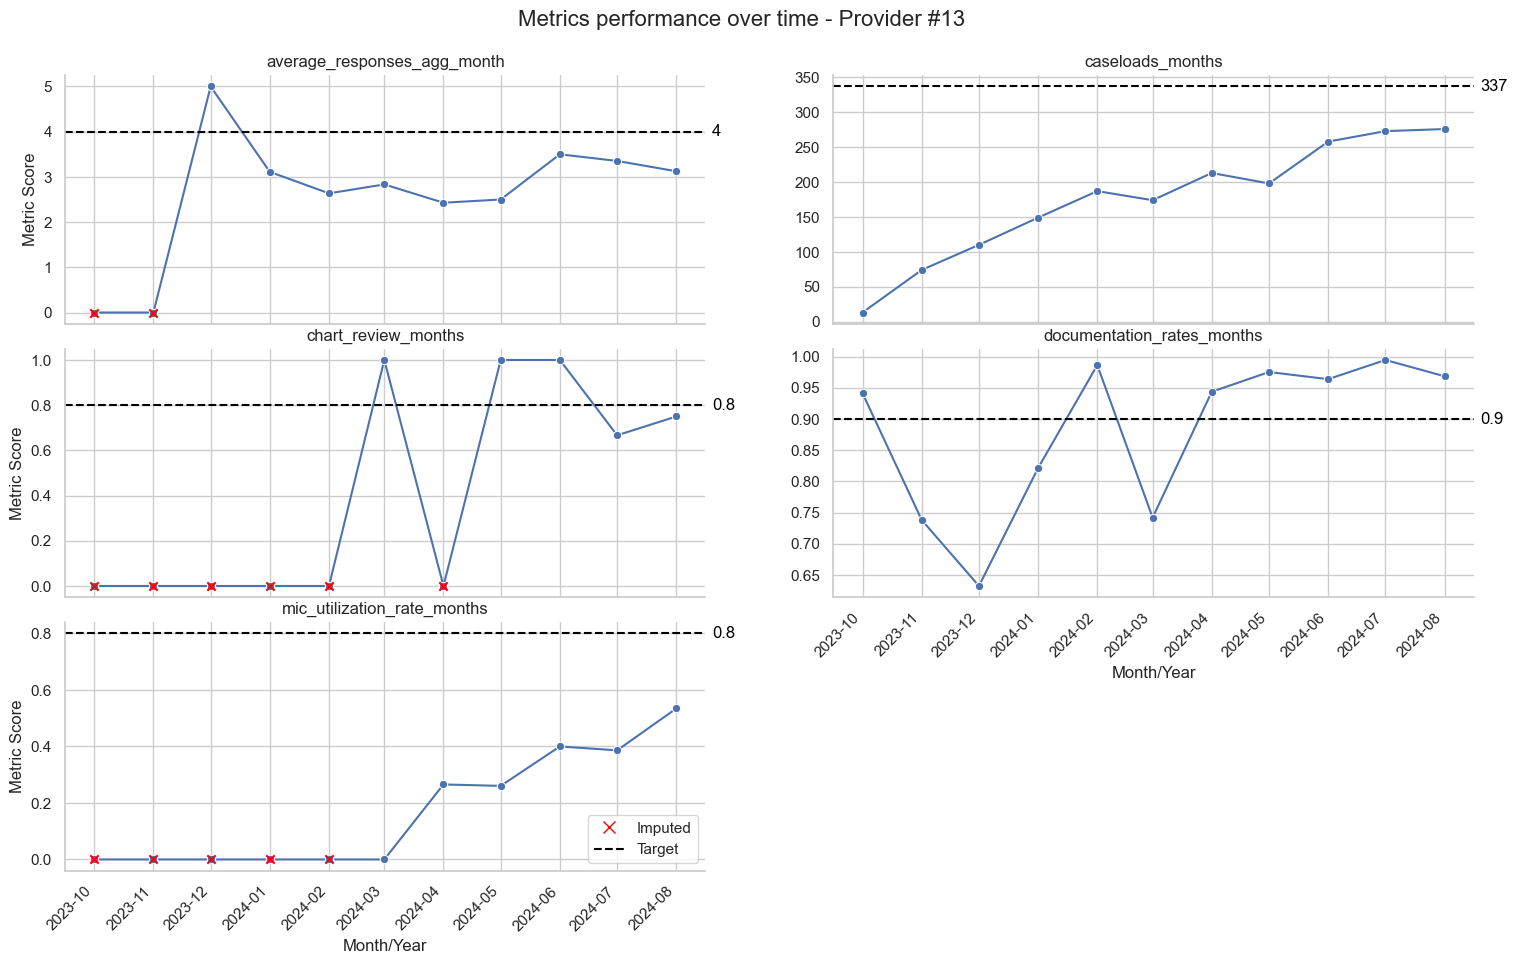

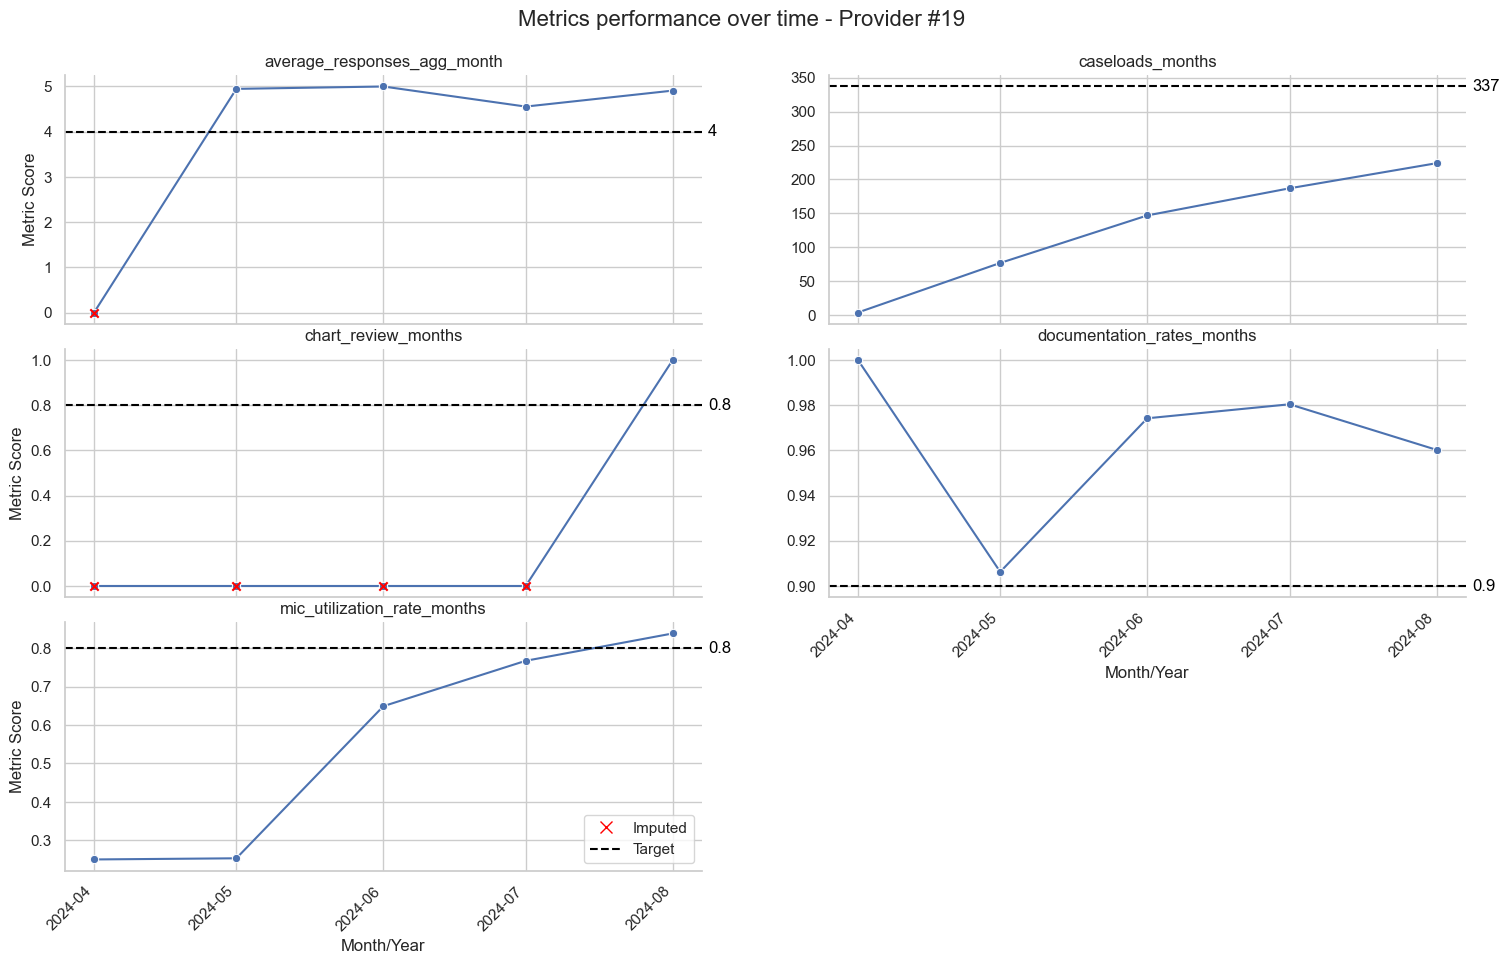

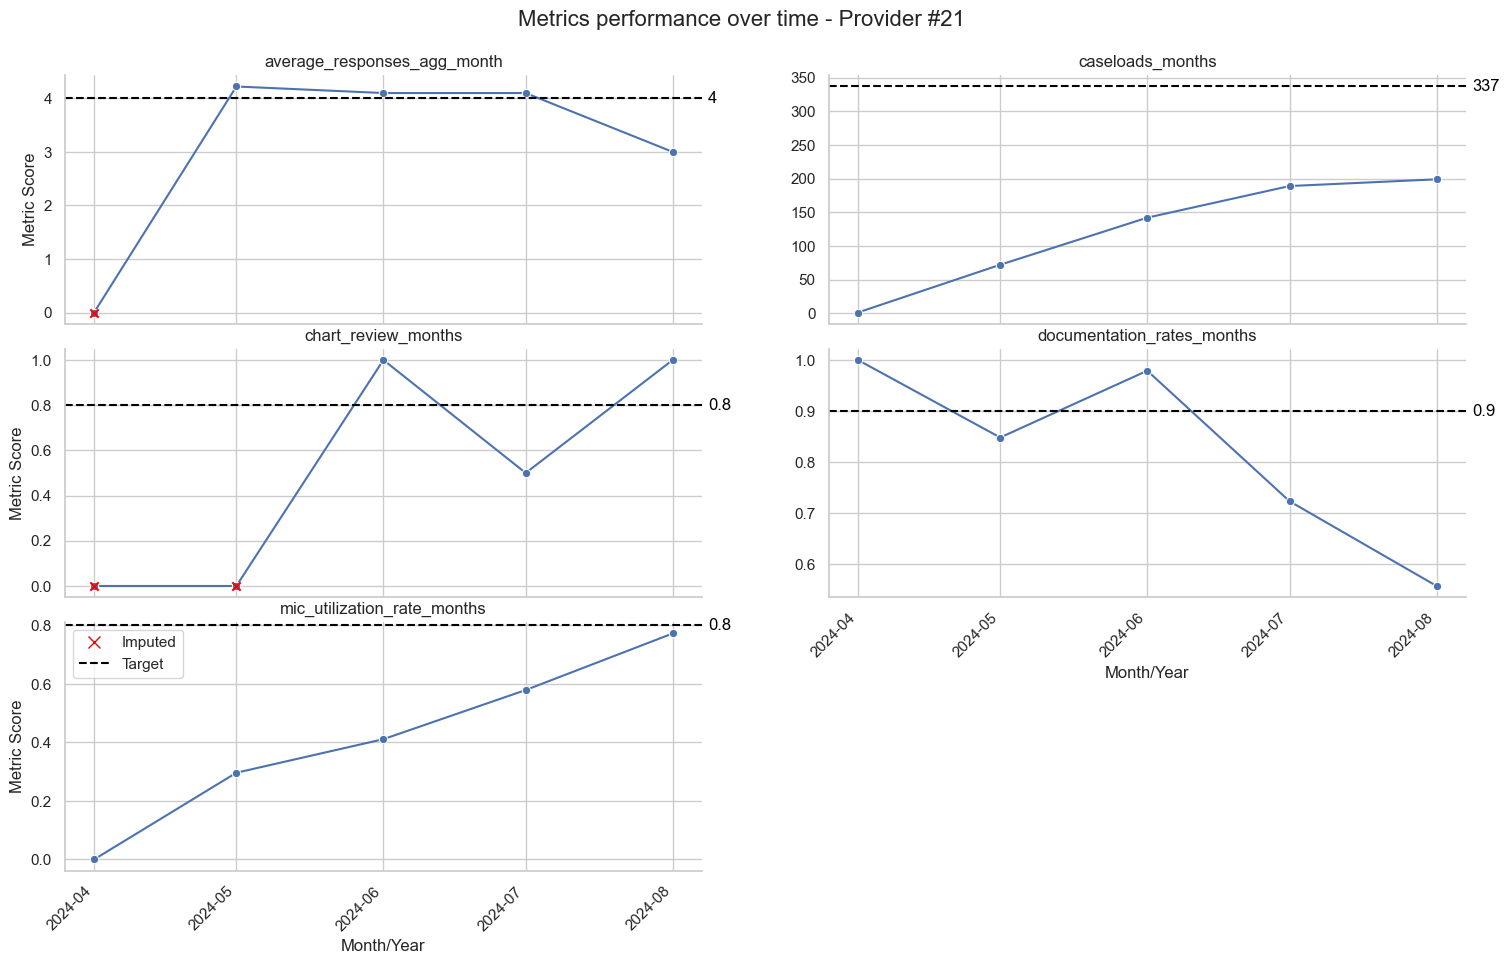

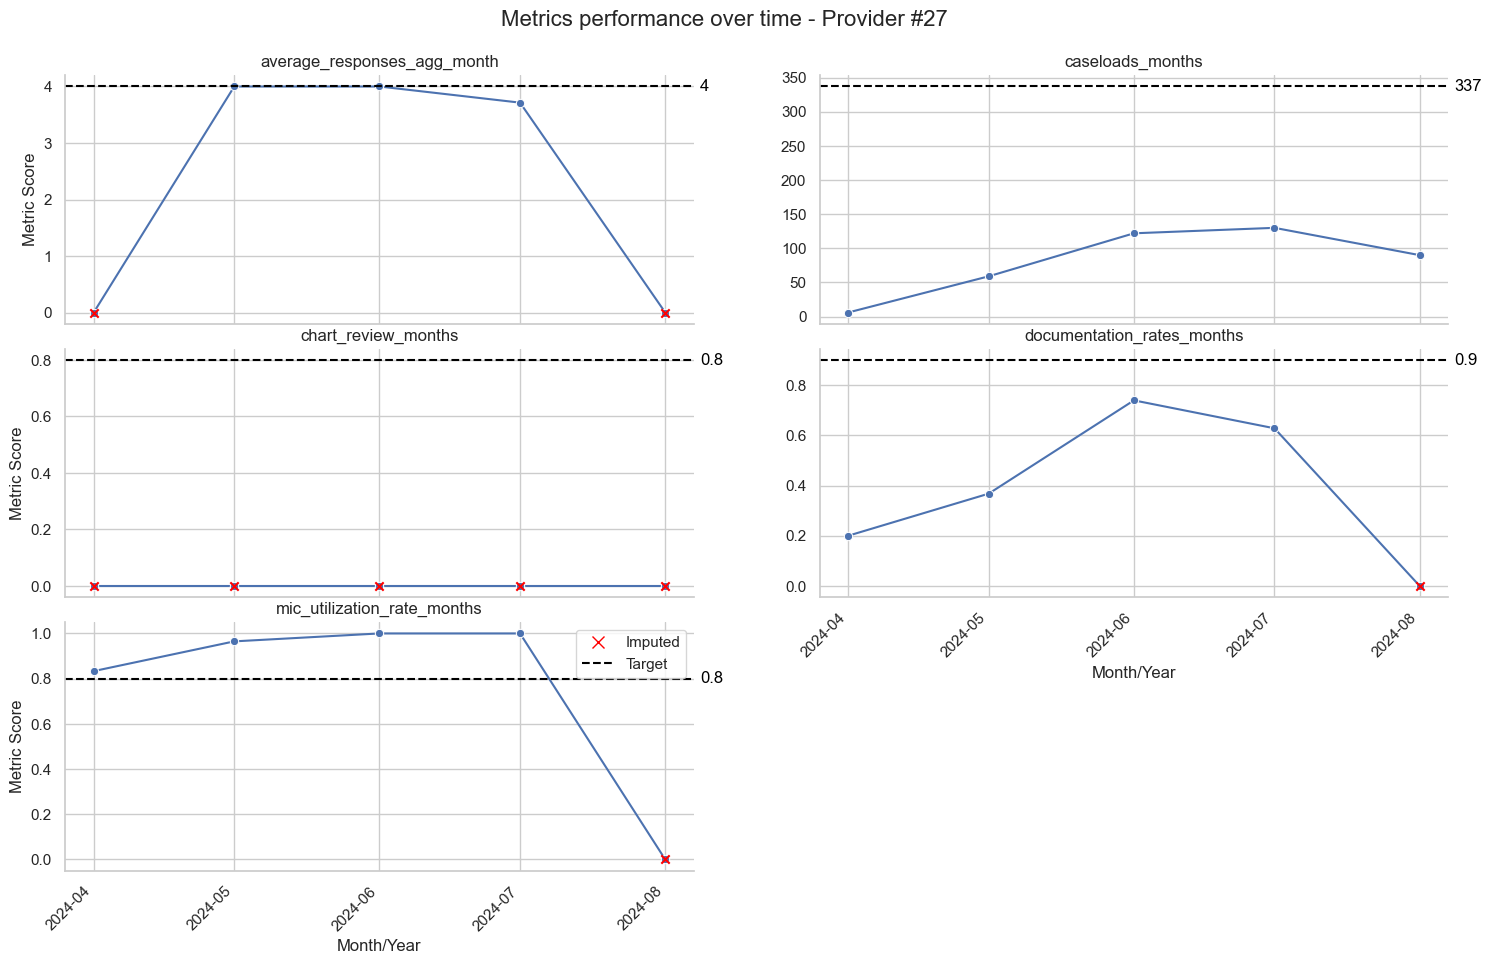

In [178]:
for provider in provider_performance_watch_list:
    create_line_graph(df_metric_score_metric_target_miss_streak, provider_id = provider)